This note implements PCA using `np.linalg.svd` and compare the results to sklearn implementation.

# Sklearn implementation

In [1]:
# adopted from https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA

iris = datasets.load_iris()

pca = PCA(n_components=2)
projected_skl = pca.fit(iris.data).transform(iris.data)

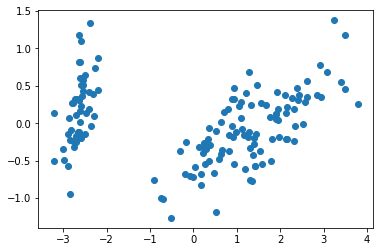

In [2]:
plt.scatter(projected_skl[:, 0], projected_skl[:, 1])

# Custom implementation

In [3]:
X = iris.data.T

In [4]:
X.shape

(4, 150)

In [5]:
n = X.shape[1]

In [6]:
X_tilde = X - X.mean(axis=1).reshape(-1, 1)

In [7]:
# Check data are standardized
np.testing.assert_allclose(X_tilde.sum(axis=1), np.zeros(len(X_tilde)), atol=1e-12)

In [8]:
U, Σ, Vh = np.linalg.svd(1 / np.sqrt(n - 1) * X_tilde)

In [9]:
# Check eigenvectors are normalized
np.testing.assert_allclose((U**2).sum(axis=1), np.ones(len(X_tilde)), atol=1e-12)

### Validates the projections of $\tilde{Y}$ match those from sklearn implementation exactly.

In [10]:
# We project both X and \tilde{X} becuase it appears that sklearn implementation projects the later
X_projected = - U[:,:2].T @ X
X_projected_tilde = - U[:,:2].T @ X_tilde

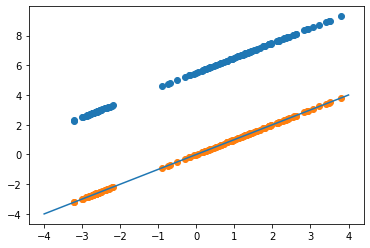

In [11]:
plt.scatter(projected_skl[:,0], X_projected[0])
plt.scatter(projected_skl[:,0], X_projected_tilde[0])
plt.plot([-4, 4], [-4, 4])

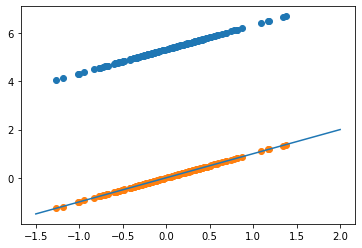

In [12]:
plt.scatter(projected_skl[:,1], X_projected[1])
plt.scatter(projected_skl[:,1], X_projected_tilde[1])
plt.plot([-1.5, 2], [-1.5, 2])

### Validates the variances match those from sklearn implementation.

In [13]:
pca.explained_variance_

array([4.22824171, 0.24267075])

In [14]:
Σ ** 2

array([4.22824171, 0.24267075, 0.0782095 , 0.02383509])

### Confirm trace of $X$ is equal to sum of eigenvalues/singular values squared.

In [15]:
np.var(X_tilde, ddof=1, axis=1).sum()

4.572957046979868

In [16]:
np.var(X, ddof=1, axis=1).sum()

4.572957046979867

In [17]:
(Σ ** 2).sum()

4.572957046979864